## SQL Integration with Python

In [87]:
# Import libraries

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
# Create a connection to an in-memory SQLite DB

conn = sqlite3.connect(':memory:') # temporal data for testing
cursor = conn.cursor()

In [89]:
# Create a simple sales table

cursor.execute('''
CREATE TABLE sales (
    sale_id INTEGER PRIMARY KEY,
    product TEXT,
    quantity INTEGER,
    price REAL,
    sale_date TEXT
)
''')

In [90]:
# Insert multiple rows into the sales table

sales_data = [
    (1, 'Laptop', 2, 1200.50, '2024-01-15'),
    (2, 'Phone', 5, 650.00, '2024-01-16'),
    (3, 'Tablet', 3, 400.25, '2024-01-17'),
    (4, 'Laptop', 1, 1300.00, '2024-01-18'),
    (5, 'Monitor', 4, 300.00, '2024-01-19')
]

cursor.executemany('''
INSERT INTO sales (sale_id, product, quantity, price, sale_date)
VALUES (?, ?, ?, ?, ?)
''', sales_data)

# Commit changes
conn.commit()

In [91]:
# Query 1: Select all records

query_all_sales = "SELECT * FROM sales"
pd.read_sql(query_all_sales, conn)

,sale_id,product,quantity,price,sale_date
0,1,Laptop,2,1200.50,2024-01-15
1,2,Phone,5,650.00,2024-01-16
2,3,Tablet,3,400.25,2024-01-17
3,4,Laptop,1,1300.00,2024-01-18
4,5,Monitor,4,300.00,2024-01-19


In [92]:
# Query 2: Total revenue per product

query_revenue_by_product = """
SELECT product, SUM(quantity * price) AS total_revenue
FROM sales
GROUP BY product
"""
pd.read_sql(query_revenue_by_product, conn)

,product,total_revenue
0,Laptop,3701.00
1,Monitor,1200.00
2,Phone,3250.00
3,Tablet,1200.75


In [93]:
# Query 3: Sales after a specific date

query_sales_after_date = """
SELECT * FROM sales
WHERE sale_date > '2024-01-16'
"""
pd.read_sql(query_sales_after_date, conn)

,sale_id,product,quantity,price,sale_date
0,3,Tablet,3,400.25,2024-01-17
1,4,Laptop,1,1300.00,2024-01-18
2,5,Monitor,4,300.00,2024-01-19


In [94]:
# Query 4: Total quantity sold for each product

query_products_quantity = """
SELECT product, SUM(quantity) AS total_quantity
FROM sales
GROUP BY product
"""
pd.read_sql(query_products_quantity, conn)

,product,total_quantity
0,Laptop,3
1,Monitor,4
2,Phone,5
3,Tablet,3


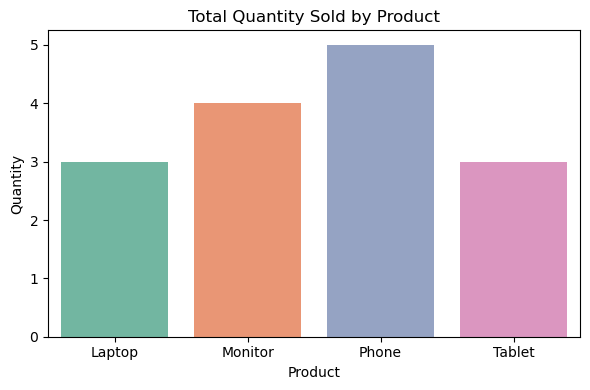

In [95]:
# Visualizing the total quantity sold per product

query_products = """
SELECT product, SUM(quantity) AS total_quantity
FROM sales
GROUP BY product
"""
df_products = pd.read_sql(query_products, conn)

# Visualize
plt.figure(figsize=(6, 4))
sns.barplot(data=df_products, x="product", y="total_quantity", hue="product", palette="Set2", legend=False)
plt.title("Total Quantity Sold by Product")
plt.xlabel("Product")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

In [96]:
# Adding another Table to practice JOINs
# Create customers table

cursor.execute('''
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY,
    name TEXT,
    city TEXT,
    country TEXT
)
''')

# Insert sample customers data
customers_data = [
    (1, 'John Smith', 'New York', 'USA'),
    (2, 'Maria Garcia', 'Madrid', 'Spain'),
    (3, 'David Chen', 'Toronto', 'Canada'),
    (4, 'Sarah Johnson', 'London', 'UK'),
    (5, 'Ahmed Hassan', 'Cairo', 'Egypt')
]

cursor.executemany('''
INSERT INTO customers (customer_id, name, city, country)
VALUES (?, ?, ?, ?)
''', customers_data)

In [97]:
# Query 5: Select all customer records

query_all_customers = "SELECT * FROM customers"
pd.read_sql(query_all_customers, conn)

,customer_id,name,city,country
0,1,John Smith,New York,USA
1,2,Maria Garcia,Madrid,Spain
2,3,David Chen,Toronto,Canada
3,4,Sarah Johnson,London,UK
4,5,Ahmed Hassan,Cairo,Egypt


In [98]:
# Check if customer_id column exists before adding it
try:
    # Add customer_id to the existing sales table
    cursor.execute('ALTER TABLE sales ADD COLUMN customer_id INTEGER')
except:
    # Column already exists, continue with the updates
    pass

# Update sales records with customer_ids
updates = [
    (1, 1),  # sale_id 1 -> John
    (2, 2),  # sale_id 2 -> Maria
    (3, 3),  # sale_id 3 -> David
    (4, 1),  # sale_id 4 -> John again
    (5, 4),  # sale_id 5 -> Sarah
]

for sale_id, customer_id in updates:
    cursor.execute('UPDATE sales SET customer_id = ? WHERE sale_id = ?', (customer_id, sale_id))

conn.commit()

In [99]:
query_with_customers = """
SELECT s.sale_id, c.name AS customer_name, c.country, s.product, s.quantity, s.price
FROM sales s
INNER JOIN customers c ON s.customer_id = c.customer_id
"""
df_sales_customers = pd.read_sql(query_with_customers, conn)
print("Sales with Customer Information:")
print(df_sales_customers)


Sales with Customer Information:
   sale_id  customer_name country  product  quantity    price
0        1     John Smith     USA   Laptop         2  1200.50
1        2   Maria Garcia   Spain    Phone         5   650.00
2        3     David Chen  Canada   Tablet         3   400.25
3        4     John Smith     USA   Laptop         1  1300.00
4        5  Sarah Johnson      UK  Monitor         4   300.00


In [100]:
# Total Revenue by Country

query_country = """
SELECT c.country, SUM(s.quantity * s.price) AS total_revenue
FROM sales s
INNER JOIN customers c ON s.customer_id = c.customer_id
GROUP BY c.country
"""
df_country = pd.read_sql(query_country, conn)

# Print the results
print("Total Revenue by Country:")
print(df_country)

Total Revenue by Country:
  country  total_revenue
0  Canada        1200.75
1   Spain        3250.00
2      UK        1200.00
3     USA        3701.00


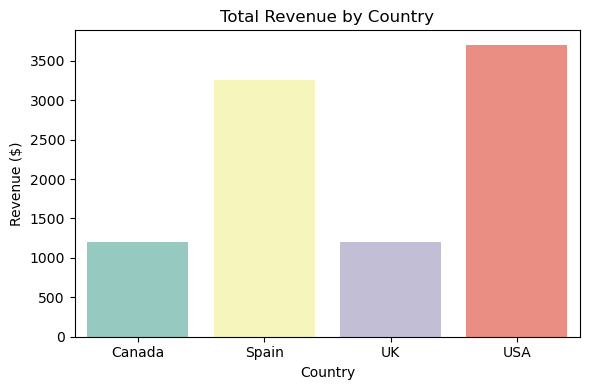

In [101]:
# Visualize the Total Revenue by Country

plt.figure(figsize=(6, 4))
sns.barplot(data=df_country, x="country", y="total_revenue", hue="country", palette="Set3", legend=False)
plt.title("Total Revenue by Country")
plt.xlabel("Country")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()